In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.get_device_name(0))  # Should return the GPU name if CUDA is working


True
NVIDIA GeForce RTX 4060 Laptop GPU


In [1]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt

class TrafficLightDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            print(f"Checking folder: {folder_path}")  # Debug: print folder path

            if not os.path.exists(folder_path):
                print(f"Warning: Subfolder '{folder_path}' does not exist. Skipping.")
                continue

            label = subfolder  # Use the subfolder name as the label

            # Loop through files in the subfolder
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                    img_path = os.path.join(folder_path, img_name)
                    print(f"Found image: {img_name}")  # Debug: print image name
                    self.data.append(img_path)
                    self.labels.append(label)

        if not self.data:
            raise ValueError("No images found in the specified subfolders.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the base directory of your dataset (use absolute path)
base_dir = r'Dataset_Traffic_Light'

# List of subfolders in your dataset
subfolders = [
    r'Annotations/Annotations',
    r'dayTrain/dayTrain', 
    r'nightTrain/nightTrain', 
    r'daySequence1/daySequence1/frames', 
    r'nightSequence1/nightSequence1/frames', 
    r'daySequence2/daySequence2/frames', 
    r'nightSequence2/nightSequence2/frames',
    # Add additional folders as needed
]


In [2]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Create the dataset
try:
    traffic_light_dataset = TrafficLightDataset(base_dir, subfolders, transform=transform)
    print(f"Dataset created successfully with {len(traffic_light_dataset)} images.")
    
    # Create a DataLoader if dataset creation is successful
    dataloader = DataLoader(traffic_light_dataset, batch_size=32, shuffle=True)
    
    # Test DataLoader
    for images, labels in dataloader:
        print(f"Batch of images: {images.shape}")  # Tensor shape: (batch_size, channels, height, width)
        print(f"Batch of labels: {labels}")  
        break

except ValueError as e:
    print(f"Error: {e}")


Checking folder: Dataset_Traffic_Light\Annotations/Annotations
Checking folder: Dataset_Traffic_Light\dayTrain/dayTrain
Checking folder: Dataset_Traffic_Light\nightTrain/nightTrain
Checking folder: Dataset_Traffic_Light\daySequence1/daySequence1/frames
Found image: daySequence1--00000.jpg
Found image: daySequence1--00001.jpg
Found image: daySequence1--00002.jpg
Found image: daySequence1--00003.jpg
Found image: daySequence1--00004.jpg
Found image: daySequence1--00005.jpg
Found image: daySequence1--00006.jpg
Found image: daySequence1--00007.jpg
Found image: daySequence1--00008.jpg
Found image: daySequence1--00009.jpg
Found image: daySequence1--00010.jpg
Found image: daySequence1--00011.jpg
Found image: daySequence1--00012.jpg
Found image: daySequence1--00013.jpg
Found image: daySequence1--00014.jpg
Found image: daySequence1--00015.jpg
Found image: daySequence1--00016.jpg
Found image: daySequence1--00017.jpg
Found image: daySequence1--00018.jpg
Found image: daySequence1--00019.jpg
Found i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


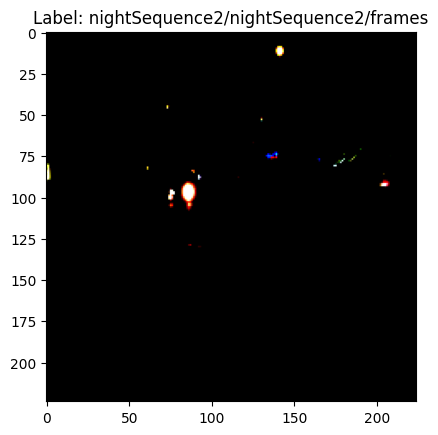

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Shuffle dataset
indices = torch.randperm(len(traffic_light_dataset)) 
shuffled_dataset = torch.utils.data.Subset(traffic_light_dataset, indices)

# Split dataset into train, validation, and test
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(shuffled_dataset, [train_size, val_size, test_size])

# Create DataLoader for each subset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Visualize one sample from the training dataset
sample_image, sample_label = next(iter(train_loader))  # Get one batch
sample_image = sample_image[0]  # Extract the first image from the batch

# Convert tensor image to numpy array for visualization
sample_image = sample_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and move to CPU

# Plot the sample image
plt.imshow(sample_image)
plt.title(f"Label: {sample_label[0]}")  # Display label for the first image in the batch
plt.show()


In [4]:
%matplotlib inline

In [5]:
import torch
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import os
import numpy as np
from PIL import Image

# Number of classes for traffic light detection (3 + 1 background)
NUM_CLASSES = 4  # Include background as class 0

# Path to the label map (manual definition in PyTorch version)
label_map = {
    1: "green",
    2: "red",
    3: "yellow"
}

# Load a pre-trained Faster R-CNN model and modify for NUM_CLASSES
model = fasterrcnn_resnet50_fpn(pretrained=True)  # Load pre-trained model
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Get number of input features for classifier
model.roi_heads.box_predictor = torch.nn.Linear(in_features, NUM_CLASSES)  # Update classifier for traffic light detection
model.eval()  # Set model to evaluation mode

# Path to your input image
PATH_TO_TEST_IMAGES_DIR = r'Dataset_Traffic_Light'
image_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, i) for i in image_list]

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

def load_image_into_numpy_array(image_path):
    try:
        # Ensure the file is an image by checking its extension
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Skipping non-image file: {image_path}")
            return None
        
        image = Image.open(image_path).convert("RGB")
        return np.array(image)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def run_inference_for_single_image(image_path, model):
    image = load_image_into_numpy_array(image_path)
    if image is None:  # Skip if image could not be loaded
        return [], [], []

    # Apply the transformations (convert to tensor and normalize)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)  # Run the model on the input image

    # Extract predictions
    boxes = outputs[0]["boxes"].cpu().numpy()  # Bounding boxes
    labels = outputs[0]["labels"].cpu().numpy()  # Class labels
    scores = outputs[0]["scores"].cpu().numpy()  # Confidence scores

    # Filter predictions based on score threshold
    threshold = 0.5
    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            filtered_boxes.append(box)
            filtered_labels.append(label)
            filtered_scores.append(score)

    return filtered_boxes, filtered_labels, filtered_scores

# Run inference on all test images
for image_path in TEST_IMAGE_PATHS:
    if not os.access(image_path, os.R_OK):  # Check if file is accessible
        print(f"Permission denied for {image_path}. Skipping.")
        continue

    filtered_boxes, filtered_labels, filtered_scores = run_inference_for_single_image(image_path, model)
    
    print(f"Detections for {image_path}:")
    for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
        print(f"Label: {label_map.get(label, 'Unknown')}, Score: {score:.2f}, Box: {box}")


c:\Users\Shravya H Jain\Desktop\Traffic\Traffic_Light_Detection_\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shravya H Jain\Desktop\Traffic\Traffic_Light_Detection_\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Skipping non-image file: Dataset_Traffic_Light\Annotations
Detections for Dataset_Traffic_Light\Annotations:
Skipping non-image file: Dataset_Traffic_Light\daySequence1
Detections for Dataset_Traffic_Light\daySequence1:
Skipping non-image file: Dataset_Traffic_Light\daySequence2
Detections for Dataset_Traffic_Light\daySequence2:
Skipping non-image file: Dataset_Traffic_Light\dayTrain
Detections for Dataset_Traffic_Light\dayTrain:
Skipping non-image file: Dataset_Traffic_Light\desktop.ini
Detections for Dataset_Traffic_Light\desktop.ini:
Skipping non-image file: Dataset_Traffic_Light\nightSequence1
Detections for Dataset_Traffic_Light\nightSequence1:
Skipping non-image file: Dataset_Traffic_Light\nightSequence2
Detections for Dataset_Traffic_Light\nightSequence2:
Skipping non-image file: Dataset_Traffic_Light\nightTrain
Detections for Dataset_Traffic_Light\nightTrain:
Skipping non-image file: Dataset_Traffic_Light\sample-dayClip6
Detections for Dataset_Traffic_Light\sample-dayClip6:
Ski

Green: 0.12, Red: 0.00, Yellow: 0.00
Green: 0.00, Red: 0.00, Yellow: 0.00
Green: 0.00, Red: 0.00, Yellow: 0.00


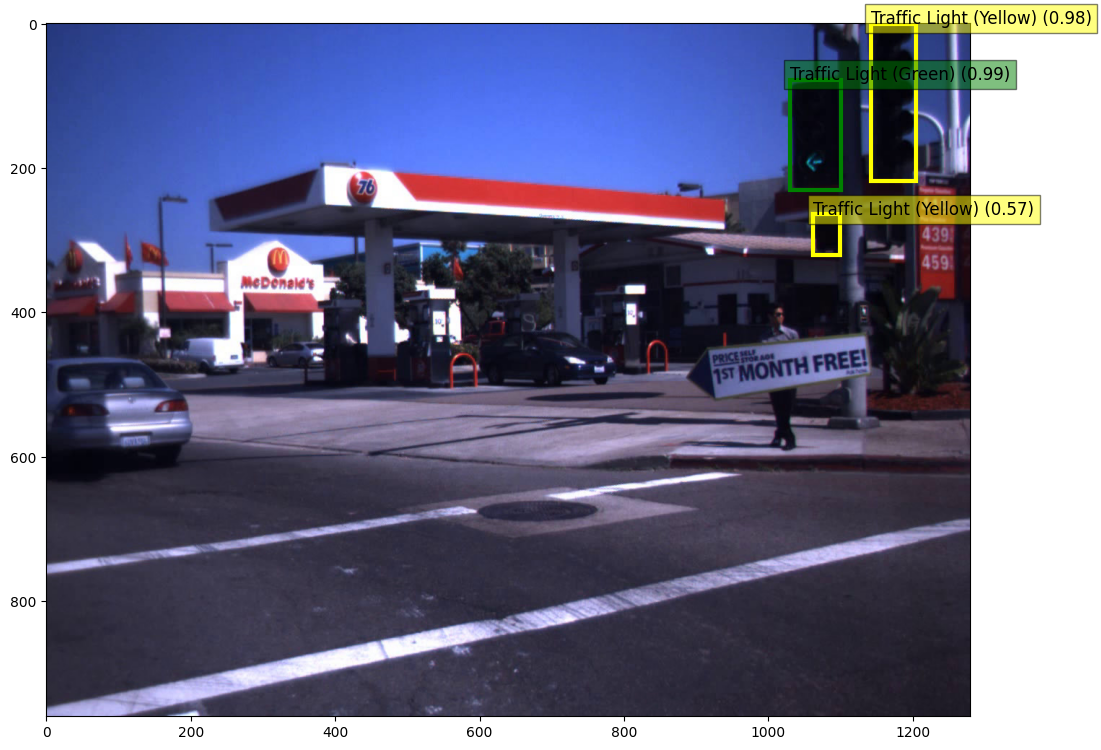

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
import cv2

# Load the pre-trained model (Faster R-CNN with a ResNet backbone)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the transform to convert image into tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor and normalize
])

# Load the image you want to process
image_path = r'Dataset_Traffic_Light/daySequence2/daySequence2/frames/daySequence2--06512.jpg'  # Replace with the actual image path
image = Image.open(image_path)

# Convert the image to a tensor and add the batch dimension
image_tensor = transform(image).unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    prediction = model(image_tensor)

# Get the prediction results
boxes = prediction[0]['boxes'].cpu().numpy()  # Bounding boxes
labels = prediction[0]['labels'].cpu().numpy()  # Class labels
scores = prediction[0]['scores'].cpu().numpy()  # Detection scores

# Assume class label for traffic light is 10 (you can verify based on your model's training)
traffic_light_class_label = 10

# Filter the results to get only traffic light detections
threshold = 0.5  # Minimum score to consider as valid detection
traffic_light_boxes = boxes[scores > threshold]
traffic_light_labels = labels[scores > threshold]
traffic_light_scores = scores[scores > threshold]

# Keep only traffic light class detections
traffic_light_boxes = traffic_light_boxes[traffic_light_labels == traffic_light_class_label]
traffic_light_scores = traffic_light_scores[traffic_light_labels == traffic_light_class_label]

# Function to detect the color of the traffic light
def detect_traffic_light_color(cropped_img):
    # Convert the cropped image to a numpy array (BGR format for OpenCV)
    cropped_img = np.array(cropped_img)
    # Convert to HSV (Hue, Saturation, Value) color space
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)
    
    # Define the color ranges for green, red, and yellow traffic lights
    green_range = ((35, 50, 50), (85, 255, 255))
    red_range_1 = ((0, 100, 100), (10, 255, 255))  # Red (low range)
    red_range_2 = ((170, 100, 100), (180, 255, 255))  # Red (high range)
    yellow_range = ((20, 100, 100), (30, 255, 255))
    
    # Mask for green
    green_mask = cv2.inRange(hsv_img, green_range[0], green_range[1])
    # Mask for red
    red_mask_1 = cv2.inRange(hsv_img, red_range_1[0], red_range_1[1])
    red_mask_2 = cv2.inRange(hsv_img, red_range_2[0], red_range_2[1])
    red_mask = cv2.bitwise_or(red_mask_1, red_mask_2)
    # Mask for yellow
    yellow_mask = cv2.inRange(hsv_img, yellow_range[0], yellow_range[1])
    
    # Calculate the percentage of each color
    green_percentage = np.sum(green_mask) / (cropped_img.shape[0] * cropped_img.shape[1])
    red_percentage = np.sum(red_mask) / (cropped_img.shape[0] * cropped_img.shape[1])
    yellow_percentage = np.sum(yellow_mask) / (cropped_img.shape[0] * cropped_img.shape[1])
    
    # Debugging: Print percentages
    print(f"Green: {green_percentage:.2f}, Red: {red_percentage:.2f}, Yellow: {yellow_percentage:.2f}")
    
    # Determine the dominant color based on the largest percentage
    if green_percentage > red_percentage and green_percentage > yellow_percentage:
        return "Green"
    elif red_percentage > yellow_percentage:
        return "Red"
    else:
        return "Yellow"

# Visualization of results
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

# Plot bounding boxes and classify color for traffic lights
for box, score in zip(traffic_light_boxes, traffic_light_scores):
    # Convert the box coordinates to integers
    box = box.astype(int)
    cropped_img = image.crop((box[0], box[1], box[2], box[3]))  # Crop the region of interest
    
    # Detect the color of the traffic light
    light_color = detect_traffic_light_color(cropped_img)
    
    # Set the bounding box color based on the detected traffic light color
    if light_color == "Green":
        box_color = "green"
    elif light_color == "Red":
        box_color = "red"
    elif light_color == "Yellow":
        box_color = "yellow"
    else:
        box_color = "white"  # Default color if detection fails
    
    # Draw the bounding box
    ax.add_patch(plt.Rectangle(
        (box[0], box[1]),  # Top-left corner
        box[2] - box[0],  # Width
        box[3] - box[1],  # Height
        fill=False,
        color=box_color,  # Use the detected color for the box
        linewidth=3
    ))
    
    # Add label, color, and score text
    ax.text(
        box[0], box[1], 
        f'Traffic Light ({light_color}) ({score:.2f})', 
        fontsize=12, 
        color='black',  # Set the text color to black
        bbox=dict(facecolor=box_color, alpha=0.5)  # Match background color to the box color
    )

plt.show()
